In [1]:
from astropy.io import fits
from astropy.table import Table,join
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from LLR import LLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
from LLR import LLR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams.update({'font.size': 22})

/global/homes/a/ashodkh/.conda/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def features_and_outcomes_classification(x_in, y_in, ivar, n_out, class_cut, l):
    EWs = np.zeros([n_out,len(lines)])
    for i in range(n_out):
        for j in range(len(lines)):
            EWs[i,j] = y_in[i][j]
    
    x_in = x_in[:n_out,:]
    ones = np.ones([n_out,1])
    scalar = StandardScaler()
    x_out = np.zeros([n_out,x_in.shape[1]-1])
    for j in range(x_in.shape[1]-1):
        x_out[:,j] = x_in[:,j] - x_in[:,j+1]
    x_out = scalar.fit_transform(x_out)
    
    if (m == 0 or m == 5):
        x_out = np.concatenate((ones,x_out), axis=1)
        
    select_yes = (EWs[:,l]>=class_cut)
    
    y_out = np.zeros(n_out)
    y_out[select_yes] = 1
        
    return x_out, y_out, ivar, EWs

In [3]:
def predict(x, y, x_test, m):   
    if m == 0:
        y_fit, zeros = LLR.LLR(x_test, x, y, 100, 'inverse_distance')
    if m == 1:
        model = RandomForestRegressor(n_estimators=200)
        model.fit(x_train, EW_train)
        EW_fit = model.predict(x_valid)
    if m == 2:
        model = GradientBoostingRegressor(n_estimators=100)
        model.fit(x_train, EW_train)
        EW_fit = model.predict(x_valid)
    if m == 3:
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)
        model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
        model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_valid,y_valid)], verbose=False)
        y_fit = model.predict(x_test)
        zeros = []
        print(model.best_ntree_limit)
    if m == 4:
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)
        
        model_input = layers.Input(shape=x.shape[1])
        h1 = layers.Dense(units=100, kernel_initializer="he_normal")(model_input)
        a1 = layers.PReLU()(h1)
        h2 = layers.Dense(units=100, kernel_initializer="he_normal")(a1)
        a2 = layers.PReLU()(h2)
        h3 = layers.Dense(units=100, kernel_initializer="he_normal")(a2)
        a3 = layers.PReLU()(h3)
        output_layer = layers.Dense(1, activation='linear')(a3)
        model = keras.models.Model(inputs=model_input, outputs=output_layer)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics='mse')

        n_epochs = 100
        batch_size = 100
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_valid, y_valid))
        y_fit = model.predict(x_test).reshape(-1)
        zeros = []

    if m == 5:
        y_fit, zeros = LLR.LLR(x_test, x, y, 500, 'inverse_distance')

    if m ==6:
        kernel = DotProduct()
        gpr = GaussianProcessRegressor(kernel=kernel)
        gpr.fit(x, EW)
        EW_fit = gpr.predict(x_test)

    return y_fit, zeros


In [5]:
server = 1 # 0 is perlmutter, 1 is cori
server_paths = ['/pscratch/sd/a/ashodkh/', '/global/cscratch1/sd/ashodkh/']


## Selecting data and doing LLR to predict lines ##
lines = ["OII_DOUBLET_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW"\
         ,"NII_6584_EW","SII_6716_EW","SII_6731_EW"]

magnitude_names = ["ABSMAG_SDSS_U", "ABSMAG_SDSS_G", "ABSMAG_SDSS_R", "ABSMAG_SDSS_I", "ABSMAG_SDSS_Z", 'ABSMAG_W1']
 
#parameters
N = 6
run_train = 0
run_test = 1
#m = 0           # model index. 0 is LLR, 1 is RandomForest, 2 is GradientBoosting from sklearn, 3 is XGboost, 4 is neural network
n_train = 25*10**3
n_test = 20*10**3
l = 6
magnitudes_train = np.zeros([n_train, len(magnitude_names)])
magnitudes_test = np.zeros([n_test, len(magnitude_names)])
for i in range(len(magnitude_names)):
    magnitudes_train[:,i] = np.load(server_paths[server]+"target_selection/" + magnitude_names[i] + "_selection" + str(run_train) + "_" + str(lines[l]) + ".txt.npz")['arr_0']
    magnitudes_test[:,i] = np.load(server_paths[server]+"target_selection/" + magnitude_names[i] + "_selection" + str(run_test) + "_test.txt.npz")['arr_0']

zs_train = np.load(server_paths[server] + "target_selection/zs_selection" + str(run_train) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
target_lines_train = np.load(server_paths[server] + "target_selection/line_ews_selection" + str(run_train) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
line_ivars_train = np.load(server_paths[server] + "target_selection/line_ivars_selection" + str(run_train) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
zs_test = np.load(server_paths[server] + "target_selection/zs_selection" + str(run_test) + "_test.txt.npz")["arr_0"]
target_lines_test = np.load(server_paths[server] + "target_selection/line_ews_selection" + str(run_test) + "_test.txt.npz")["arr_0"]
line_ivars_test = np.load(server_paths[server] + "target_selection/line_ivars_selection" + str(run_test) + "_test.txt.npz")["arr_0"]

n_train = 23*10**3
n_test = 18*10**3



    
m_j = [3,4]
y_fit_j = np.zeros([n_test,len(m_j)])
for j in range(len(m_j)):
    m = m_j[j]
    x, y, ivar, EW = features_and_outcomes_classification(magnitudes_train, target_lines_train, line_ivars_train, int(n_train), class_cut=3, l=6)
    x_test, y_test, ivar_test, EW_test = features_and_outcomes_classification(magnitudes_test, target_lines_test, line_ivars_test, int(n_test), class_cut=3, l=6)
    
    # predicting EWs using different models
    y_fit, zeros = predict(x, y, x_test, m)
    # calculating meaningful stats for classification like false positive number, false positive rates, etc...

    y_fit_j[:,j] = y_fit[:]

# np.savez_compressed(server_paths[server] + "ew_results/ugriz/m" +str(m)+ "/test_logEW_fit_ugriz_selection"+str(run_train)+"_line"+str(lines[l])+"_bins"+str(N)\
#                         +"_ML"+str(m)+".txt", EW_fit)
# np.savez_compressed(server_paths[server] + "ew_results/ugriz/m" +str(m)+ "/test_EW_obs_ugriz_selection"+str(run_train)+"_line"+str(lines[l])+"_bins"+str(N)\
#                         +"_ML"+str(m)+".txt", EW_test)
# np.savez_compressed(server_paths[server] + "ew_results/ugriz/m" +str(m)+ "/test_line_ivars_ugriz_selection"+str(run_train)+"_line"+str(lines[l])+"_bins"+str(N)\
#                         +"_ML"+str(m)+".txt", ivar_test)



74


2022-09-05 08:30:50.996776: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-05 08:30:50.997133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-05 08:30:50.999933: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 32. Tune using inter_op_parallelism_threads for best performance.
2022-09-05 08:30:51.106764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-05 08:30:51.129158: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300045000 Hz


In [6]:
threshold = np.arange(0, 1.01, 0.01)
nt = len(threshold)
tpr = np.zeros([nt,len(m_j)])
tnr = np.zeros([nt,len(m_j)])
fpr = np.zeros([nt,len(m_j)])

for j in range(len(m_j)):
    for i in range(nt):
        y_fit_01 = np.zeros(n_test)
        y_fit_01[y_fit_j[:,j]>threshold[i]] = 1

        tp = sum(y_test*y_fit_01)
        fp = sum(np.logical_not(y_test)*y_fit_01)
        tn = sum(np.logical_not(y_test)*(np.logical_not(y_fit_01)))
        fn = sum(y_test*(np.logical_not(y_fit_01)))

        tpr[i,j] = tp/(tp+fn)
        tnr[i,j] = tn/(tn+fp)
        fpr[i,j] = fp/(fp+tn)

IndexError: index 2 is out of bounds for axis 1 with size 2

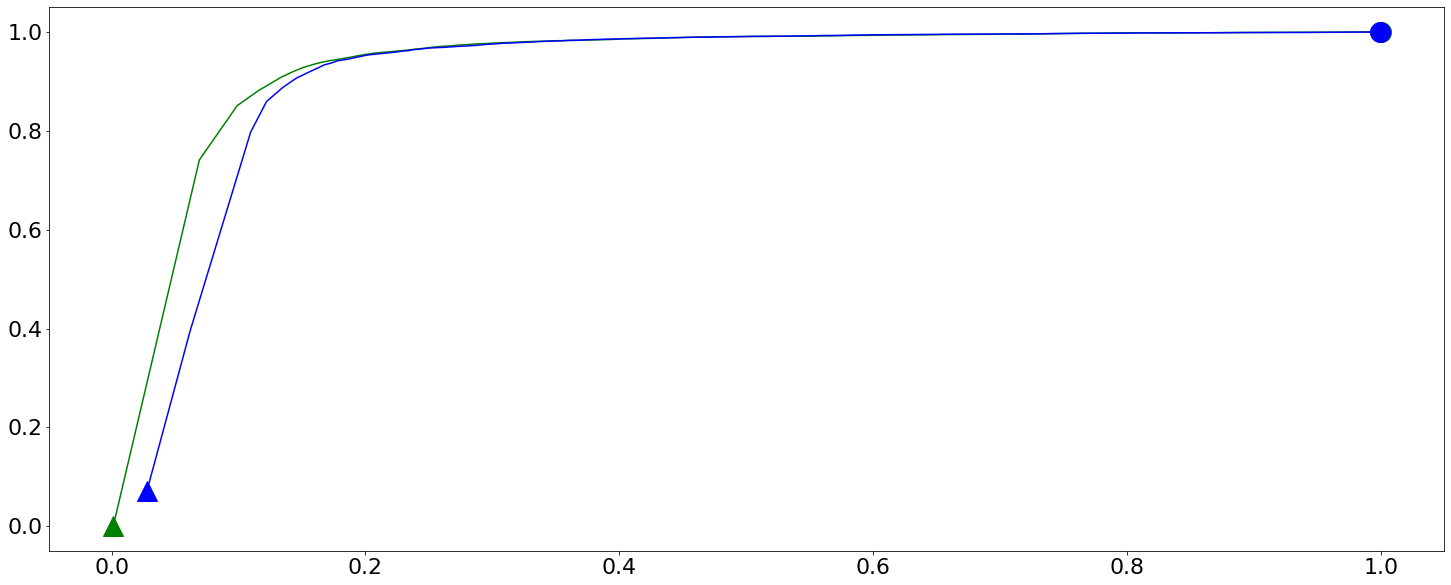

In [7]:
m_names = ['LLR 100', 'LLR 800', 'XGBoost']
m_colors = ['g', 'b', 'r']
for i in range(3):
    plt.figure(1)
    plt.plot(fpr[:,i], tpr[:,i], color=m_colors[i], label = m_names[i])
    plt.plot(fpr[0,i], tpr[0,i], 'o', markersize=20, color=m_colors[i], label = 'threshold= '+str(threshold[0]))
    plt.plot(fpr[-1,i], tpr[-1,i], '^', markersize=20, color=m_colors[i], label = 'threshold= '+str(threshold[-1]))
plt.xlabel('false posistive rate')
plt.ylabel('true positive rate')
plt.legend()

In [ ]:
plt.hist(y_fit, bins=100)

In [ ]:
plt.hist(y_test,bins=100)

In [ ]:
plt.figure(1)
plt.plot(fpr0, tpr0, '*', label='LLR 100')
plt.plot(fpr5, tpr5, '*', label='LLR 800')
plt.plot(fpr6, tpr6, '*', label='XGboost')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()

In [ ]:
plt.hist(EW[:,6], range=(0,100), bins=100)

In [ ]:
plt.hist(EW_test[:,6], range=(0,100), bins=100)